Основная цель исследования — проанализировать данные абитуриентов на предмет их распределения по направлениям подготовки в зависимости от баллов ЕГЭ, а также применить методы балансировки данных для улучшения работы моделей машинного обучения.

Загрузка библиотек:

In [42]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import EditedNearestNeighbours



Баллы ЕГЭ — это непрерывные данные, которые могут принимать любые значения в пределах диапазона (например, от 0 до 300). Преобразование их в категориальные переменные (диапазоны баллов) теряет информацию о реальных различиях между абитуриентами. Например, разница между 250 и 255 баллами может быть значительной, но если оба значения попадают в один диапазон, эта информация теряется, то есть если студент хотел поступить на бюджет, то он определенно не будет выбирать направление с 255 баллами порога, поэтому мы сгенереруем баллы и статус обучающего: контракт или бюджет

In [51]:
# Чтение данных из CSV файла
df = pd.read_csv('NSTU_Students_data.csv', usecols=['Направление подготовки', 'Сумма баллов ЕГЭ за 3 предмета'])

# Таблица с направлениями и порогами для бюджета
budget_thresholds = {
    "Информатика и вычислительная техника": 245,
    "Программная инженерия": 265,
    "Прикладная информатика": 240,
    "Информационная безопасность": 235,
    "Информационная безопасность автоматизированных систем": 220,
    "Приборостроение": 215,
    "Биотехнические системы и технологии": 210,
    "Управление в технических системах": 170,
    "Информационные системы и технологии": 225
}

# Функция для определения статуса и случайного балла
def determine_status(row):
    direction = row['Направление подготовки']
    score_range = list(map(int, row['Сумма баллов ЕГЭ за 3 предмета'].split('-')))
    min_score, max_score = score_range

    # Генерируем случайный балл
    random_score = random.randint(min_score, max_score)

    # Получаем порог для бюджета из словаря
    budget_score = budget_thresholds.get(direction, None)

    # Определяем статус
    if budget_score is not None and random_score >= budget_score:
        status = "Бюджет"
    else:
        status = "Контракт"

    return random_score, status

# Применение функции к DataFrame
df['Сгенерированные баллы'], df['Статус'] = zip(*df.apply(determine_status, axis=1))

# Подготовка данных для дальнейшего анализа
df_results = df[['Направление подготовки', 'Сгенерированные баллы', 'Статус']]

# Маппинг направлений на числа
direction_mapping = {
    "Управление в технических системах": 1,
    "Биотехнические системы и технологии": 2,
    "Приборостроение": 3,
    "Информационная безопасность автоматизированных систем": 4,
    "Информационные системы и технологии": 5,
    "Информационная безопасность": 6,
    "Прикладная информатика": 7,
    "Информатика и вычислительная техника": 8,
    "Программная инженерия": 9
}

# Применение маппинга
df_results['Направление подготовки'] = df_results['Направление подготовки'].map(direction_mapping)
df_results['Статус'] = df_results['Статус'].map({'Бюджет': 1, 'Контракт': 0})
print(df_results)

     Направление подготовки  Сгенерированные баллы  Статус
0                         8                    254       1
1                         2                    230       1
2                         8                    214       0
3                         6                    164       0
4                         5                    241       1
..                      ...                    ...     ...
421                       8                    253       1
422                       2                    205       0
423                       6                    208       0
424                       5                    249       1
425                       8                    232       0

[426 rows x 3 columns]


<ipython-input-51-3b7ab79b93f0>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['Направление подготовки'] = df_results['Направление подготовки'].map(direction_mapping)
<ipython-input-51-3b7ab79b93f0>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['Статус'] = df_results['Статус'].map({'Бюджет': 1, 'Контракт': 0})


к как, у нас данные очень несбалансированные применим методы under_samping'а, такой как SMOTE — метод синтетического увеличения данных для классов меньшинства с целью балансировки.

In [52]:
X = df_results[['Сгенерированные баллы', 'Статус']]
y = df_results[['Направление подготовки']]
original_class_counts = y['Направление подготовки'].value_counts()
print("Количество классов до SMOTE:\n", original_class_counts)

sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X, y)
df_results = pd.DataFrame(X_resampled, columns=['Сгенерированные баллы', 'Статус'])
df_results['Направление подготовки'] = y_resampled

# Подсчет классов после применения SMOTE
resampled_class_counts = df_results['Направление подготовки'].value_counts()
print("Количество классов после SMOTE:\n", resampled_class_counts)

Количество классов до SMOTE:
 Направление подготовки
8    127
6     59
7     44
2     39
4     38
9     38
1     35
5     33
3     13
Name: count, dtype: int64
Количество классов после SMOTE:
 Направление подготовки
8    127
2    127
6    127
5    127
4    127
9    127
7    127
1    127
3    127
Name: count, dtype: int64


Как мы видим, теперь данные более менее сбалансированны. Теперь разделим наши данные на группы бюджет и контракт, и применим к ним тоже баласировку, так как из-за высоких баллов, например на программмной инженерии, может оказатьсяя, что на контракте будет много человек. Теперь применим SMOTEENN — комбинация SMOTE и ENN (Edited Nearest Neighbors), которая позволяет не только увеличить количество примеров для классов меньшинства, но и удалить шумные данные.

Количество классов до SMOTEENN (Бюджет):
 Направление подготовки
1    127
2    109
4     87
5     62
8     58
9     55
7     55
6     52
3     17
Name: count, dtype: int64
Количество классов до SMOTEENN (Контракт):
 Направление подготовки
3    110
6     75
9     72
7     72
8     69
5     65
4     40
2     18
Name: count, dtype: int64


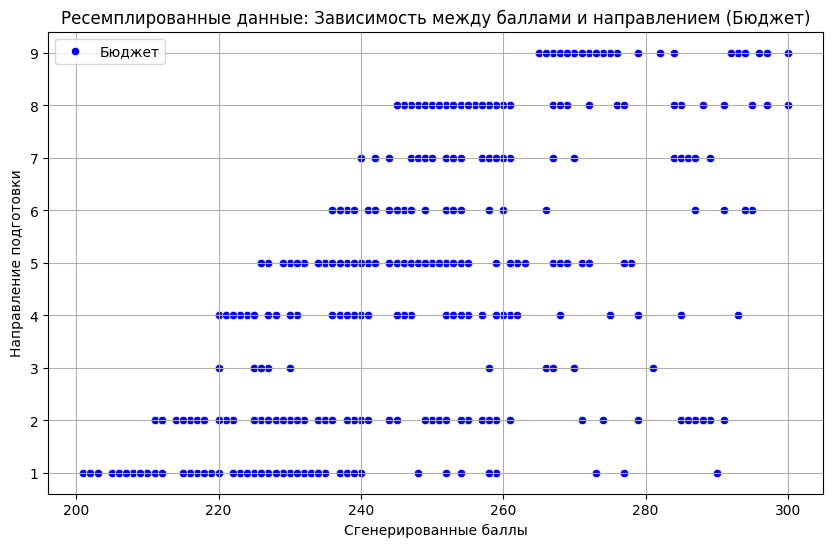

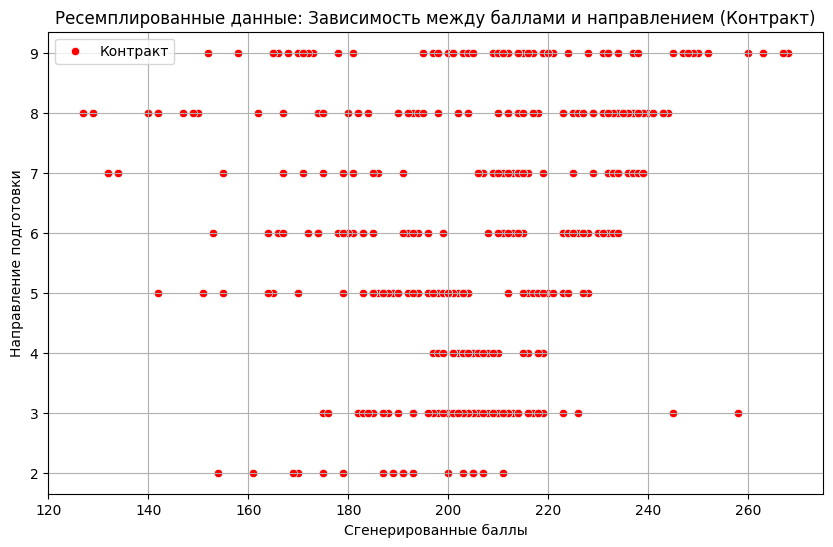

Количество классов после SMOTEENN (Бюджет):
 Направление подготовки
1    127
9     56
6     53
8     14
2     13
3     10
7      8
4      6
5      5
Name: count, dtype: int64
Количество классов после SMOTEENN (Контракт):
 Направление подготовки
2    110
8     34
9     22
3     18
6     15
5     13
7      7
4      6
Name: count, dtype: int64


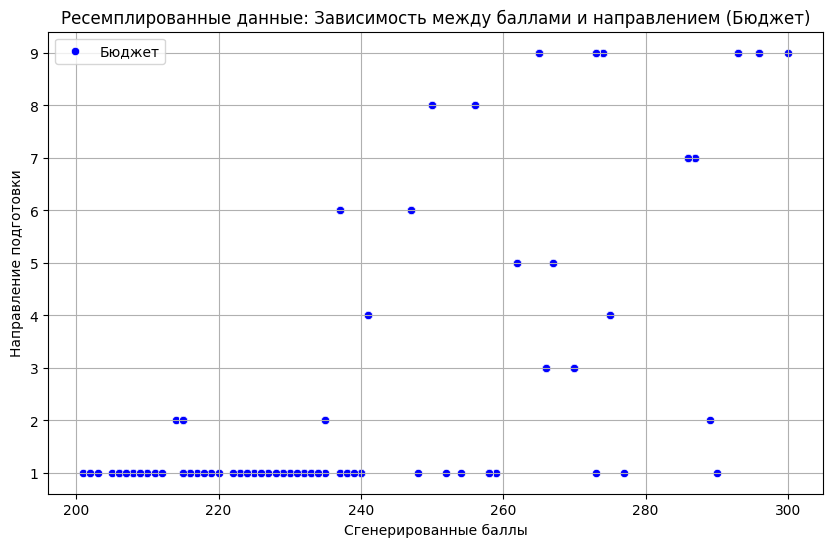

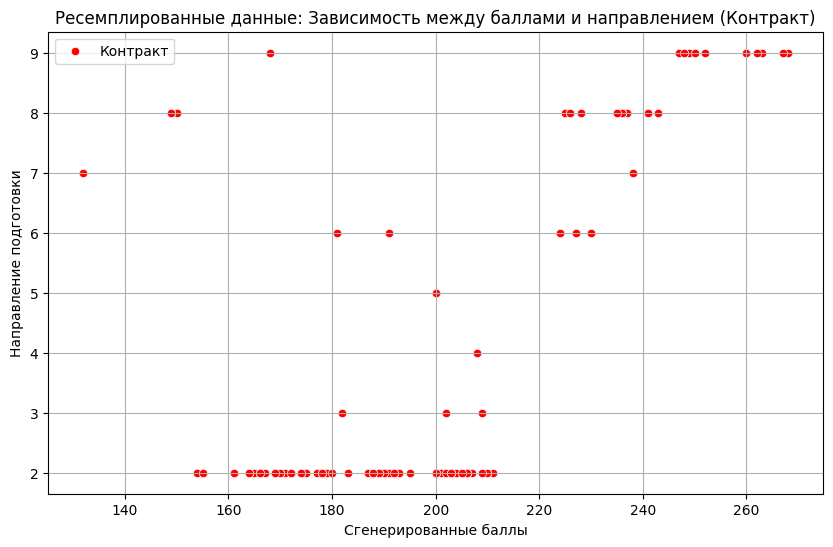

In [68]:
# Разделение данных на бюджетные и контрактные
budget_data = df_results[df_results['Статус'] == 1]
contract_data = df_results[df_results['Статус'] == 0]
print("Количество классов до SMOTEENN (Бюджет):\n", budget_data['Направление подготовки'].value_counts())
print("Количество классов до SMOTEENN (Контракт):\n", contract_data['Направление подготовки'].value_counts())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=budget_data['Сгенерированные баллы'],
                y=budget_data['Направление подготовки'],
                label="Бюджет", color="blue")
plt.xlabel('Сгенерированные баллы')
plt.ylabel('Направление подготовки')
plt.title('Ресемплированные данные: Зависимость между баллами и направлением (Бюджет)')
plt.grid()
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x=contract_data['Сгенерированные баллы'],
                y=contract_data['Направление подготовки'],
                label="Контракт", color="red")
plt.xlabel('Сгенерированные баллы')
plt.ylabel('Направление подготовки')
plt.title('Ресемплированные данные: Зависимость между баллами и направлением (Контракт)')
plt.grid()
plt.show()
# Применение ENN для бюджетных данных
X_budget = budget_data[['Сгенерированные баллы']]
y_budget = budget_data['Направление подготовки']
enn = EditedNearestNeighbours(n_neighbors=2)
smoteenn = SMOTEENN(sampling_strategy='auto',enn=enn, random_state=42)

X_budget_resampled, y_budget_resampled = smoteenn.fit_resample(X_budget, y_budget)

# Применение ENN для контрактных данных
X_contract = contract_data[['Сгенерированные баллы']]
y_contract = contract_data['Направление подготовки']
#smoteenn_contract = SMOTEENN(sampling_strategy='auto', random_state=42)
X_contract_resampled, y_contract_resampled = smoteenn.fit_resample(X_contract, y_contract)

# Создание DataFrame с результатами ресемплинга для бюджета и контракта
resampled_budget_df = pd.DataFrame(X_budget_resampled, columns=['Сгенерированные баллы'])
resampled_budget_df['Направление подготовки'] = y_budget_resampled.values

resampled_contract_df = pd.DataFrame(X_contract_resampled, columns=['Сгенерированные баллы'])
resampled_contract_df['Направление подготовки'] = y_contract_resampled.values

print("Количество классов после SMOTEENN (Бюджет):\n", resampled_budget_df['Направление подготовки'].value_counts())
print("Количество классов после SMOTEENN (Контракт):\n", resampled_contract_df['Направление подготовки'].value_counts())
plt.figure(figsize=(10, 6))
sns.scatterplot(x=resampled_budget_df['Сгенерированные баллы'],
                y=resampled_budget_df['Направление подготовки'],
                label="Бюджет", color="blue")
plt.xlabel('Сгенерированные баллы')
plt.ylabel('Направление подготовки')
plt.title('Ресемплированные данные: Зависимость между баллами и направлением (Бюджет)')
plt.grid()
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x=resampled_contract_df['Сгенерированные баллы'],
                y=resampled_contract_df['Направление подготовки'],
                label="Контракт", color="red")
plt.xlabel('Сгенерированные баллы')
plt.ylabel('Направление подготовки')
plt.title('Ресемплированные данные: Зависимость между баллами и направлением (Контракт)')
plt.grid()
plt.show()


После балансировки данных модель логистической регрессии была обучена для предсказания направления подготовки по сгенерированным баллам ЕГЭ для каждой категории.

In [69]:
X_budget = resampled_budget_df[['Сгенерированные баллы']]
y_budget = resampled_budget_df['Направление подготовки']
X_budget_train, X_budget_test, y_budget_train, y_budget_test = train_test_split(X_budget, y_budget, test_size=0.2)

# Модель логистической регрессии для бюджета
log_reg_budget = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=42)
log_reg_budget.fit(X_budget_train, y_budget_train)

# Предсказание на тестовой выборке
y_budget_pred = log_reg_budget.predict(X_budget_test)

# Вывод отчета о классификации и точности для бюджета
print("Отчет о классификации для тестовых бюджетных данных:\n", classification_report(y_budget_test, y_budget_pred))
print("Точность для тестовых бюджетных данных:", accuracy_score(y_budget_test, y_budget_pred))


# Разделение данных на обучающую и тестовую выборки для контракта
X_contract = resampled_contract_df[['Сгенерированные баллы']]
y_contract = resampled_contract_df['Направление подготовки']
X_contract_train, X_contract_test, y_contract_train, y_contract_test = train_test_split(X_contract, y_contract, test_size=0.2, random_state=42)

# Модель логистической регрессии для контракта
log_reg_contract = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
log_reg_contract.fit(X_contract_train, y_contract_train)

# Предсказание на тестовой выборке
y_contract_pred = log_reg_contract.predict(X_contract_test)

# Вывод отчета о классификации и точности для контракта
print("Отчет о классификации для тестовых контрактных данных:\n", classification_report(y_contract_test, y_contract_pred))
print("Точность для тестовых контрактных данных:", accuracy_score(y_contract_test, y_contract_pred))

Отчет о классификации для тестовых бюджетных данных:
               precision    recall  f1-score   support

           1       0.74      0.88      0.81        26
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1
           6       0.57      0.57      0.57         7
           7       0.00      0.00      0.00         1
           9       0.76      1.00      0.86        16

    accuracy                           0.73        59
   macro avg       0.26      0.31      0.28        59
weighted avg       0.60      0.73      0.66        59

Точность для тестовых бюджетных данных: 0.7288135593220338
Отчет о классификации для тестовых контрактных данных:
               precision    recall  f1-score   support

           2       0.55      1.00      0.71        16
           3       0.00      0.00      0.00         5
           5     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

Анализ:
Нелинейное расположение данных: Результаты для контрактных данных указывают на наличие значительного разброса между классами. Это может быть связано с тем, что данные не имеют линейного расположения, что усложняет задачу классификации, поэтому подключение других признаков поможет увеличить точность.
Улучшение точности: Ручное удаление экземпляров данных из классов, где количество экземпляров на направлении "Бюджет" превышает таковое в направлении "Контракт", может помочь сбалансировать классы и повысить точность модели. Это позволит улучшить обучение модели за счет уменьшения влияния дисбаланса классов на результаты классификации.